# KNN
Here we use K Nearest Neighbors algorithm to perform classification and regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from rdkit import Chem, DataStructs
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from tqdm.notebook import tqdm

## Load Data

In [2]:
# training data:
assays = pd.read_pickle('../processed_data/combined_dataset.pkl')
assays = assays[assays.activity_target.isin(['Active', 'Inactive'])]  # get rid of any 'Inconclusive'

dcm = pd.read_pickle('../processed_data/DarkChemicalMatter_processed.pkl.gz')

# testing data:
screening_data = pd.read_pickle('../processed_data/screening_data_processed.pkl')

# Classification

## Load training data

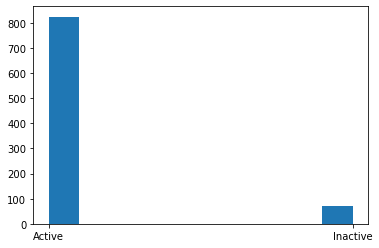

In [3]:
# set up features (X) and labels (y) for knn
X_assays = np.stack(assays.morgan_fingerprint)
y_assays = assays.activity_target.values
assays_hist = plt.hist(y_assays)

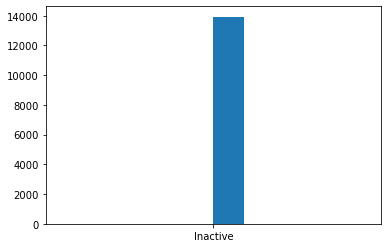

In [4]:
X_dcm = np.stack(dcm.sample(frac=.1).morgan_fingerprint)
y_dcm = ['Inactive'] * len(X_dcm)
dcm_hist = plt.hist(y_dcm)

### Validation

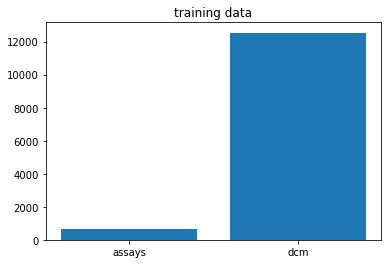

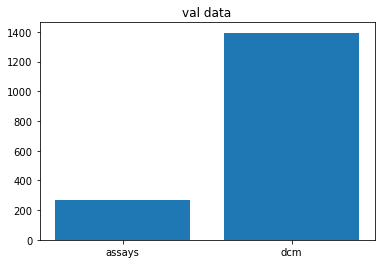

In [5]:
# make a validation set out of some of the assays and some of the dcm
percent_test_assays = .3  # Make the val set a bit less skewed than the train set
percent_test_dcm = .1    #
random_state = 3 # for reproducibility of train/val split

train_X_assays, val_X_assays, train_y_assays, test_y_assays = train_test_split(X_assays, y_assays, test_size=percent_test_assays, random_state=random_state)
train_X_dcm, val_X_dcm, train_y_dcm, test_y_dcm = train_test_split(X_dcm, y_dcm, test_size=percent_test_dcm, random_state=random_state)

plt.figure()
plt.bar(['assays', 'dcm'], [len(train_X_assays), len(train_X_dcm)])
plt.title('training data')

plt.figure()
plt.bar(['assays', 'dcm'], [len(val_X_assays), len(val_X_dcm)])
plt.title('val data')

train_X = np.concatenate([train_X_assays, train_X_dcm], axis=0)
val_X = np.concatenate([val_X_assays, val_X_dcm], axis=0)
train_y = np.concatenate([train_y_assays, train_y_dcm], axis=0)
test_y = np.concatenate([test_y_assays, test_y_dcm], axis=0)

## Optimize KNN Classifier using Validation Data

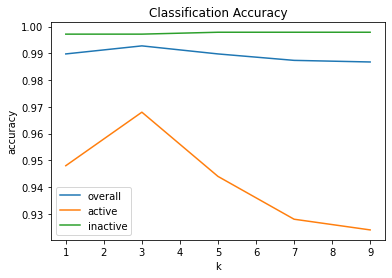

In [6]:
# optimize knn, test a couple ks

ks = np.arange(1, 10, 2)

accuracies = []
active_accuracies = []
inactive_accuracies = []
for k in tqdm(ks):
    nbrs = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', weights='distance', n_jobs=32)
    nbrs.fit(train_X, train_y)
    pred = nbrs.predict(val_X)
    accuracies.append(np.count_nonzero(pred == test_y) / len(test_y))
    if np.count_nonzero(test_y == 'Inactive') == 0:
        inactive_accuracies.append(1)  # all inactive classified correctly: vacuously true
    else:
        inactive_accuracies.append(np.count_nonzero((pred == test_y) & (pred == 'Inactive')) / np.count_nonzero(test_y == 'Inactive'))
    if np.count_nonzero(test_y == 'Active') == 0:
        active_accuracies.append(1)
    else:
        active_accuracies.append(np.count_nonzero((pred == test_y) & (test_y == 'Active')) / np.count_nonzero(test_y == 'Active'))

plt.figure()
plt.plot(ks, accuracies, label='overall')
plt.plot(ks, active_accuracies, label='active')
plt.plot(ks, inactive_accuracies, label='inactive')
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title('Classification Accuracy')
plt.legend()

From the above experiment, we can see that k=3 does the best.

## Test on the Screening Data

In [7]:
# set up train and test
X_train = np.concatenate([X_assays, X_dcm])
y_train = np.concatenate([y_assays, y_dcm])

X_test = np.stack(screening_data.morgan_fingerprint)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

Training set size: 14827
Test set size: 21011


In [9]:
nbrs = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', weights='distance', n_jobs=32) # turns out it gets much faster with many jobs (even 8x more jobs than my laptop's 4 physical cores).  64 is slower than 32 though, overhead catches up I guess.
nbrs.fit(train_X, train_y)

# chunk the test set in order to get some sense of progress
pred = []
for test_chunk in tqdm(np.array_split(X_test, 100)):
    pred.append(nbrs.predict(test_chunk))
pred = np.concatenate(pred)

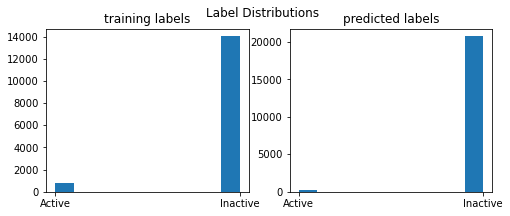

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(y_train)
ax[0].set_title('training labels')
ax[1].hist(pred)
ax[1].set_title('predicted labels')
t = plt.suptitle('Label Distributions')

We can see the screening data mostly comes back as inactive.  The distribution is similar to the training distribution, which could mean the model is biased by the training distribution, but this isn't necessarily true.  Could use a test with different training data distribution to see.

# Regression
Now that we have identified active compounds out of the screening data, we can regress the activity of these compounds using our assay data.

### Load Train/Test Data
Features are still morgan fingerprints, labels are activity values.  Where available, the activity values are scaled to tmprss2 based on correlation between target activities.  Where correlation was unavailable, activity values are unscaled.

The test data consists of all the screening molecules which were marked 'active' in classification above.

In [11]:
X_assays = np.stack(assays.morgan_fingerprint)
y_assays = np.log10(assays.acvalue_scaled_to_tmprss2.fillna(assays.acvalue_target))
assert y_assays.isna().sum() == 0

active_screening_data = screening_data[pred=='Active']
X_test_active = np.stack(active_screening_data.morgan_fingerprint)

In [12]:
nbrs = KNeighborsRegressor(n_neighbors=3, weights='distance') # still use 3 neighbors, as that worked best for classification
nbrs.fit(X_assays, y_assays)
pred_acvalue = nbrs.predict(X_test_active)

active_screening_data.insert(loc=2, column='predicted_acvalue(log10)', value=pred_acvalue)

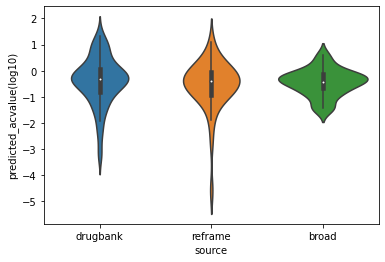

In [13]:
# a look at the predicted activity distributions by dataset source:
from seaborn import violinplot
violinplot(x='source', y='predicted_acvalue(log10)', data=active_screening_data)

In [14]:
# and the top hits!
active_screening_data.sort_values(by='predicted_acvalue(log10)').head(20)

,source,name,predicted_acvalue(log10),morgan_fingerprint
10797,reframe,Nafamostat,-4.573860,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
8202,drugbank,Thymopentin,-3.298473,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2513,drugbank,RWJ-56423,-3.210095,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2928,drugbank,RWJ-51084,-3.197638,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7893,drugbank,Depreotide,-3.156262,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8073,drugbank,Angiotensin II,-2.816777,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
10813,reframe,BMS-654457,-2.698970,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4849,drugbank,Aviptadil,-2.523425,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
10244,drugbank,Avexitide,-2.425083,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
9879,drugbank,Taspoglutide,-2.392246,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Nafamostat comes in on top, which is reassuring.  Reframe is highly represented in the top hits considering its comparatively small size, which validates Stefano's intuitions in cherry-picking that database.